In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install imantics
# !pip install patchify

  Preparing metadata (setup.py) ... done
  Created wheel for imantics: filename=imantics-0.1.12-py3-none-any.whl size=16009 sha256=4e462f4fc0140b378ddec56ae86769032d5ec43c354a1eec3c4dc577f37731ca
  Stored in directory: /root/.cache/pip/wheels/40/e1/8d/fd1fa8f30722831661afc8e6efcda609c72d1b73e11f4d49b7
Successfully built imantics
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 109.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 wh

# extract polygons from seg model and extract it from pre, post and traget mask

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf


@tf.keras.utils.register_keras_serializable(package="Custom")
def bulinding_iou(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    # Only keep patches that have some damage
    mask = tf.reduce_sum(y_true, axis=[1,2,3]) > 0
    y_true = tf.boolean_mask(y_true, mask)
    y_pred = tf.boolean_mask(y_pred, mask)

    # If no damage patches exist, return 0
    def compute_iou():
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
        union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3]) - intersection
        return tf.reduce_mean(intersection / (union + 1e-7))

    return tf.cond(tf.size(y_true) > 0, compute_iou, lambda: 0.0)

@tf.keras.utils.register_keras_serializable(package="Custom")
def bulinding_f1_per_class(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    # Only damage class
    intersection = tf.reduce_sum(y_true * y_pred)
    precision = intersection / (tf.reduce_sum(y_pred) + 1e-7)
    recall = intersection / (tf.reduce_sum(y_true) + 1e-7)
    return 2 * precision * recall / (precision + recall + 1e-7)
model = load_model(
    "/content/drive/MyDrive/bulinding_seg_resnet34.keras",
    custom_objects={
        "bulinding_iou": bulinding_iou,
        "bulinding_f1_per_class": bulinding_f1_per_class
    },
    compile=False  # safer for custom losses
)

### first load the images

In [ ]:
import os

path = "/content/drive/MyDrive/"
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))



import os
import glob
from pprint import pprint

base_dir   = "/content/drive/MyDrive/sample_data_150_tr"
image_pre  = os.path.join(base_dir, "pre_image")
image_post = os.path.join(base_dir, "post_image")
target_dir = os.path.join(base_dir, "target_mask")
label_dir  = os.path.join(base_dir, "label_json")

train_dict = {}

# loop over all target masks
for target_path in glob.glob(os.path.join(target_dir, '*.png')):
    filename = os.path.basename(target_path)
    base_id = filename.replace('.png', '')

    # now filenames match directly
    pre_img  = os.path.join(image_pre,  base_id + '.png')
    post_img = os.path.join(image_post, base_id + '.png')
    label_json = os.path.join(label_dir, base_id + '.json')

    if os.path.exists(pre_img) and os.path.exists(post_img):
        train_dict[base_id] = {
            'pre_image': pre_img,
            'post_image': post_img,
            'target_mask': target_path,
            'label_json': label_json if os.path.exists(label_json) else None
        }
    else:
        print(f"Missing: {base_id}")
        if not os.path.exists(pre_img):
            print(" - Missing pre:", pre_img)
        if not os.path.exists(post_img):
            print(" - Missing post:", post_img)

# Show a sample entry
pprint(dict(list(train_dict.items())[:1]))


Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/croped_pre_post_bulinding/palu-tsunami_00000072_building_160_pre.png
/content/drive/MyDrive/croped_pre_post_bulinding/palu-tsunami_00000072_building_160_post.png
/content/drive/MyDrive/croped_pre_post_bulinding/palu-tsunami_00000072_building_161_pre.png
/content/drive/MyDrive/croped_pre_post_bulinding/palu-tsunami_00000072_building_161_post.png
/content/drive/MyDrive/croped_pre_post_bulinding/palu-tsunami_00000072_building_162_pre.png
/content/drive/MyDrive/croped_pre_post_bulinding/palu-tsunami_00000072_building_162_post.png
/content/drive/MyDrive/croped_pre_post_bulinding/palu-tsunami_00000072_building_163_pre.png
/content/drive/MyDrive/croped_pre_post_bulinding/palu-tsunami_00000072_building_163_post.png
/content/drive/MyDrive/croped_pre_post_bulinding/palu-tsunami_00000072_building_164_pre.png
/content/drive/MyDrive/croped_pre_post_bulinding/palu-tsunami_00000072_building_164_post.png
/content/drive/MyDrive/c

### demo of the croped polygons from the seg models

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
Skipped polygon 9: invalid or empty -> shape=(1, 2)

✅ Total buildings extracted: 17 / 18 polygons detected



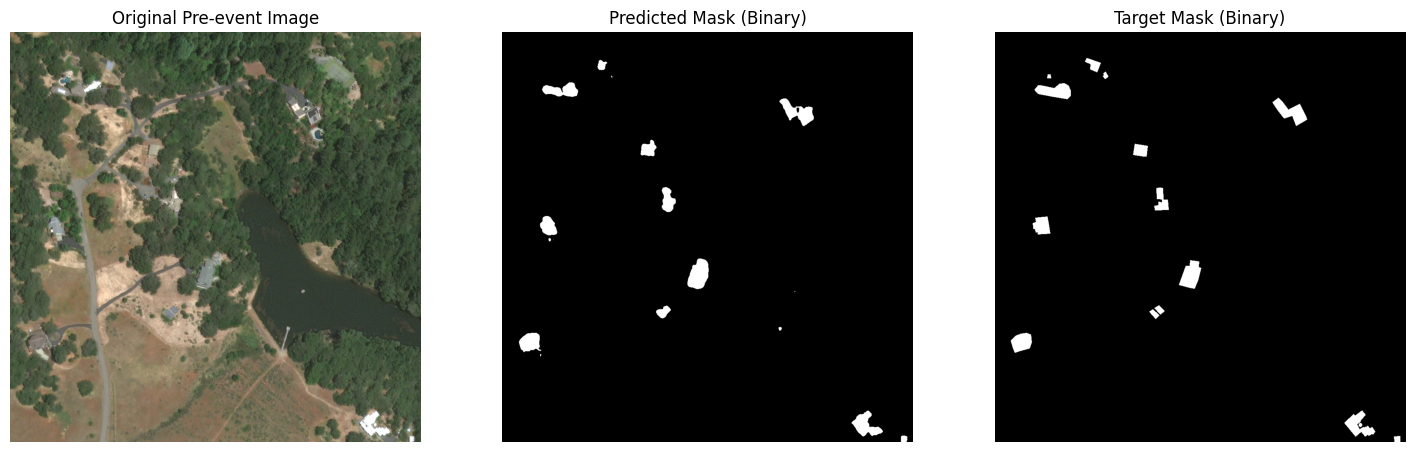

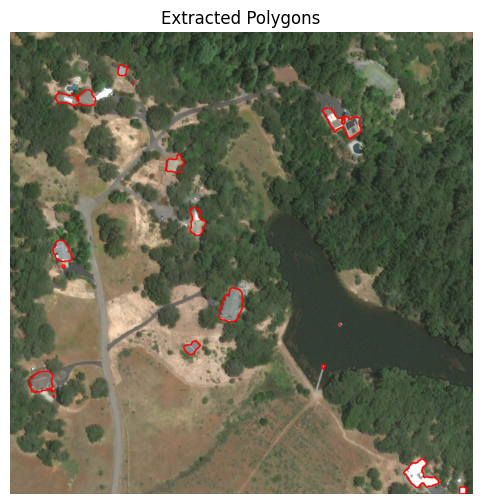

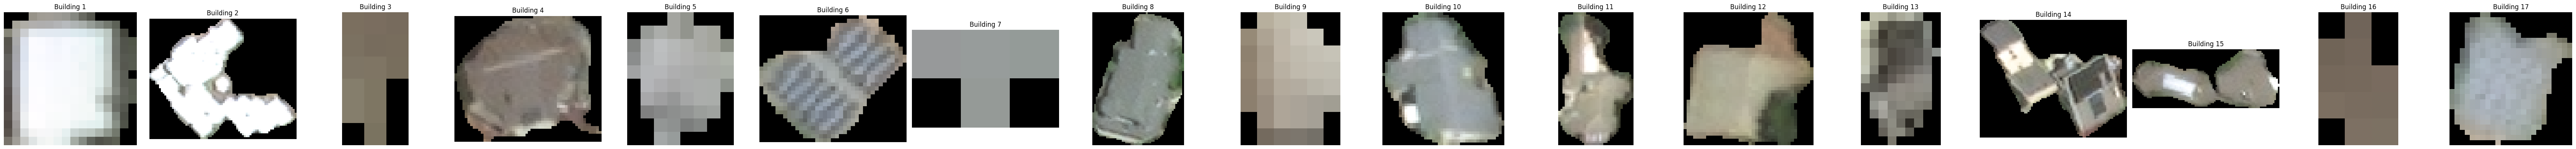

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from patchify import patchify
from imantics import Mask
import cv2

# --------------------- Full image prediction ---------------------
def model_predict_full_image(img_pre, model, patch_size=256, step=128):
    h, w = img_pre.shape[:2]
    pad_h = (patch_size - h % patch_size) % patch_size
    pad_w = (patch_size - w % patch_size) % patch_size
    img_pre_padded = np.pad(img_pre.astype(np.float32)/255.0, ((0,pad_h),(0,pad_w),(0,0)), mode='reflect')

    # Patchify
    patches = patchify(img_pre_padded, (patch_size, patch_size, 3), step=step)
    patches = patches[:,:,0,:,:,:]
    n_h, n_w = patches.shape[:2]
    flat_patches = patches.reshape(-1, patch_size, patch_size, 3)

    # Predict
    preds_flat = model.predict(flat_patches, batch_size=8)
    if preds_flat.shape[-1] != 1:
        preds_flat = np.expand_dims(preds_flat[...,0], axis=-1)

    # Reconstruct full mask
    prob_map = np.zeros((img_pre_padded.shape[0], img_pre_padded.shape[1]), dtype=np.float32)
    weight_map = np.zeros_like(prob_map)
    gx = np.linspace(-1,1,patch_size)
    gw = np.exp(-0.5*(gx**2)/0.25**2)
    gw2d = np.outer(gw, gw)
    idx = 0
    for i in range(n_h):
        for j in range(n_w):
            y0, x0 = i*step, j*step
            y1, x1 = y0+patch_size, x0+patch_size
            prob_map[y0:y1, x0:x1] += preds_flat[idx,...,0]*gw2d
            weight_map[y0:y1, x0:x1] += gw2d
            idx += 1
    weight_map[weight_map==0] = 1.0
    y_pred_full = (prob_map/weight_map)[:h,:w]
    y_pred_bin = (y_pred_full>0.5).astype(np.uint8)
    return y_pred_bin

# --------------------- Overlay polygons ---------------------
def overlay_polygons(image, polygons, color=(255,0,0)):
    img_copy = image.copy()
    for poly in polygons:
        coords = np.array(poly, dtype=np.int32)
        if len(coords) >= 3:
            coords = coords.reshape((-1,1,2))
            cv2.polylines(img_copy, [coords], isClosed=True, color=color, thickness=2)
    return img_copy

# --------------------- Crop valid polygons safely ---------------------
def crop_polygon(img, poly):
    coords = np.array(poly)

    # Handle flat 1D polygons by reshaping into Nx2
    if coords.ndim == 1:
        coords = coords.reshape(-1, 2)

    # Only use polygons with >=3 points
    if len(coords) < 3:
        return None

    # Ensure valid integers
    coords = coords.astype(np.int32)

    # Make mask
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [coords], 1)

    # Crop area
    cropped = cv2.bitwise_and(img, img, mask=mask)
    x, y, w, h = cv2.boundingRect(coords)
    return cropped[y:y+h, x:x+w]

# --------------------- Main execution ---------------------
img_id = list(train_dict.keys())[70]
info = train_dict[img_id]
img_pre = np.array(Image.open(info['pre_image']).convert("RGB"))

# Predict mask
y_pred_bin = model_predict_full_image(img_pre, model)

# Extract polygons
mask = Mask(y_pred_bin)
polygons = mask.polygons()
polygons = polygons.points  # ✅ Convert to list of coordinate arrays

# Overlay polygons
img_pre_poly = overlay_polygons(img_pre, polygons)

# Crop polygons
cropped_buildings = []
for i, poly in enumerate(polygons):
    crop = crop_polygon(img_pre, poly)
    if crop is not None:
        cropped_buildings.append(crop)
    else:
        print(f"Skipped polygon {i+1}: invalid or empty -> shape={np.array(poly).shape if poly is not None else 'None'}")

print(f"\n✅ Total buildings extracted: {len(cropped_buildings)} / {len(polygons)} polygons detected\n")

# --------------------- Prepare target mask ---------------------
target_mask = np.array(Image.open(info['target_mask']).convert("L"))  # Load grayscale
target_mask_bin = (target_mask > 0).astype(np.uint8)  # Binary: 1=building, 0=background

# --------------------- Visualization: pre-image, predicted, target ---------------------
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(img_pre)
plt.title("Original Pre-event Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(y_pred_bin, cmap='gray')
plt.title("Predicted Mask (Binary)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(target_mask_bin, cmap='gray')
plt.title("Target Mask (Binary)")
plt.axis("off")

plt.show()

# --------------------- Visualization: polygons ---------------------
plt.figure(figsize=(12,6))
plt.imshow(img_pre_poly)
plt.title("Extracted Polygons")
plt.axis("off")
plt.show()

# --------------------- Plot all cropped buildings horizontally ---------------------
if len(cropped_buildings) > 0:
    n = len(cropped_buildings)
    plt.figure(figsize=(4*n, 4))  # Width depends on number of crops

    for i, crop in enumerate(cropped_buildings):
        plt.subplot(1, n, i+1)
        plt.imshow(crop)
        plt.title(f"Building {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No valid cropped buildings found.")


## analysis the the croped images from pre & post and also with decision rules for the lables


🧠 Debugging image: santa-rosa-wildfire_00000324
Pred shape: (1024, 1024), Pre shape: (1024, 1024, 3)
Total predicted polygons: 13


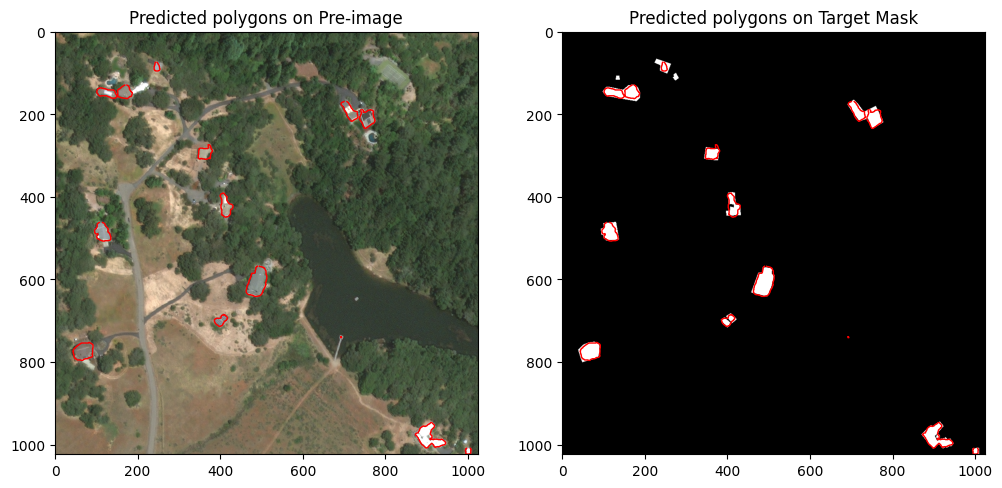


🧱 Image: santa-rosa-wildfire_00000324 | Building 0
📊 Pixel counts per class: {0: 15, 4: 210}
📉 Class percentages: {0: 6.67, 4: 93.33}
✅ Final assigned damage class: 4


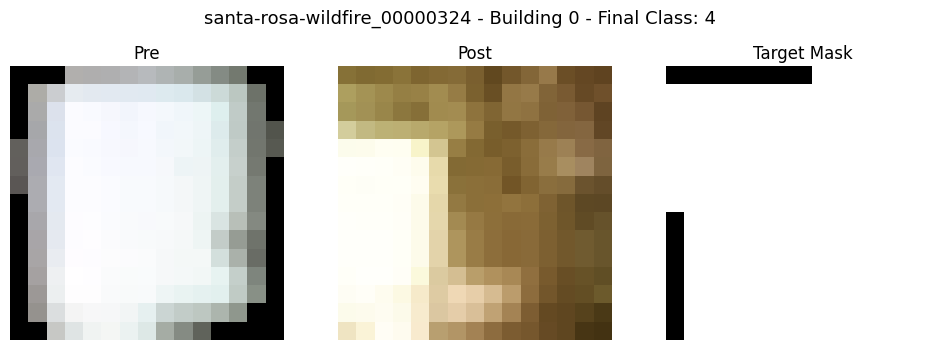


🧱 Image: santa-rosa-wildfire_00000324 | Building 1
📊 Pixel counts per class: {0: 2281, 4: 2307}
📉 Class percentages: {0: 49.72, 4: 50.28}
✅ Final assigned damage class: 4


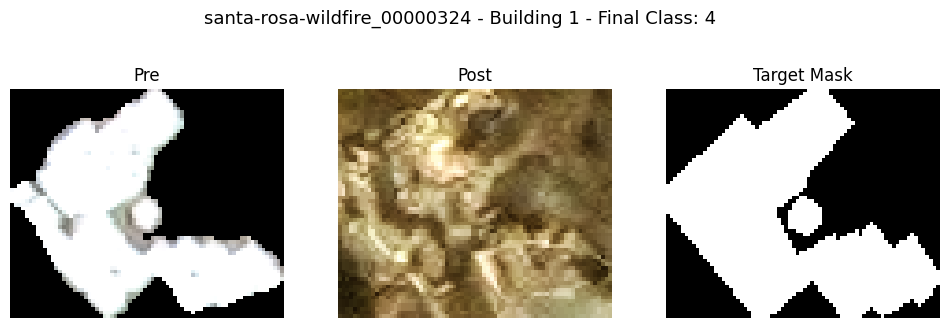


🧱 Image: santa-rosa-wildfire_00000324 | Building 2
📊 Pixel counts per class: {0: 380, 4: 1820}
📉 Class percentages: {0: 17.27, 4: 82.73}
✅ Final assigned damage class: 4


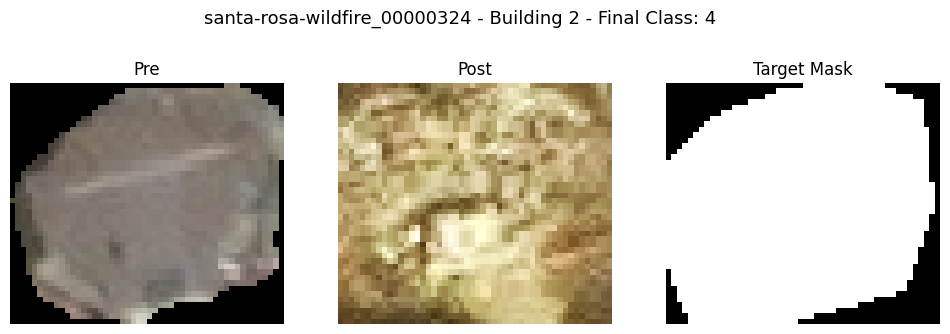

⚠️  Skipping tiny polygon (w=3, h=3)

🧱 Image: santa-rosa-wildfire_00000324 | Building 4
📊 Pixel counts per class: {0: 427, 4: 563}
📉 Class percentages: {0: 43.13, 4: 56.87}
✅ Final assigned damage class: 4


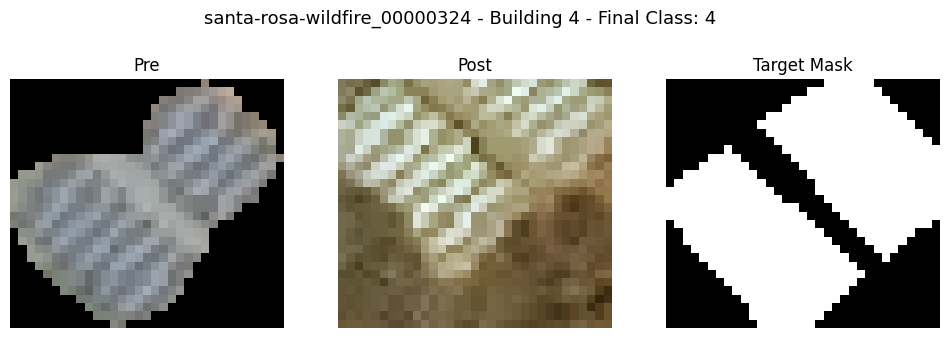


🧱 Image: santa-rosa-wildfire_00000324 | Building 5
📊 Pixel counts per class: {0: 1286, 4: 2488}
📉 Class percentages: {0: 34.08, 4: 65.92}
✅ Final assigned damage class: 4


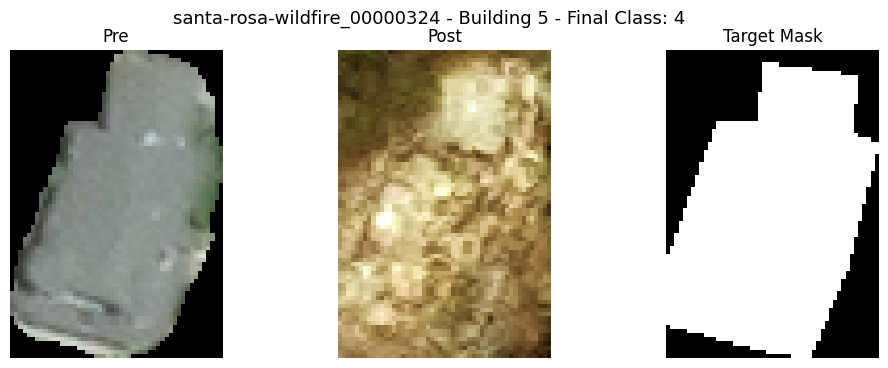


🧱 Image: santa-rosa-wildfire_00000324 | Building 6
📊 Pixel counts per class: {0: 350, 4: 1490}
📉 Class percentages: {0: 19.02, 4: 80.98}
✅ Final assigned damage class: 4


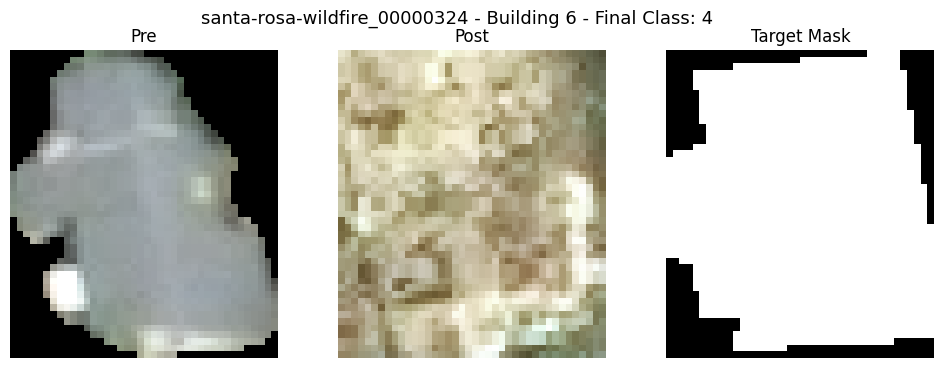


🧱 Image: santa-rosa-wildfire_00000324 | Building 7
📊 Pixel counts per class: {0: 718, 4: 1170}
📉 Class percentages: {0: 38.03, 4: 61.97}
✅ Final assigned damage class: 4


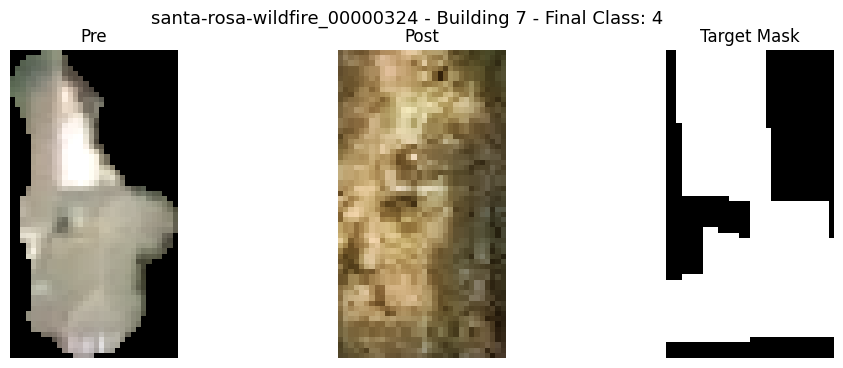


🧱 Image: santa-rosa-wildfire_00000324 | Building 8
📊 Pixel counts per class: {0: 412, 4: 884}
📉 Class percentages: {0: 31.79, 4: 68.21}
✅ Final assigned damage class: 4


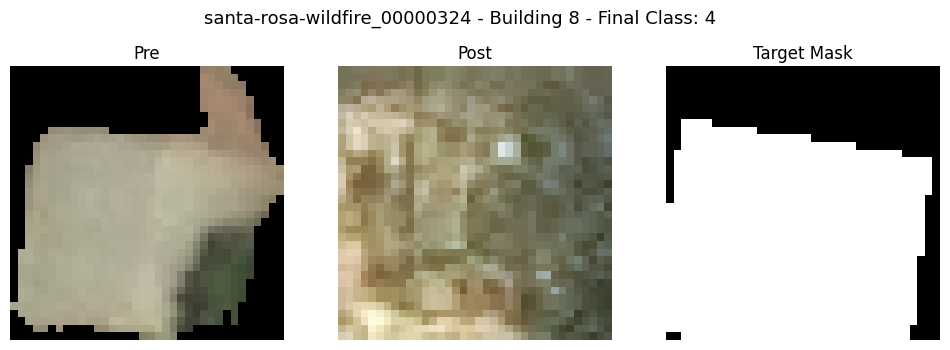


🧱 Image: santa-rosa-wildfire_00000324 | Building 9
📊 Pixel counts per class: {0: 471, 4: 1277}
📉 Class percentages: {0: 26.95, 4: 73.05}
✅ Final assigned damage class: 4


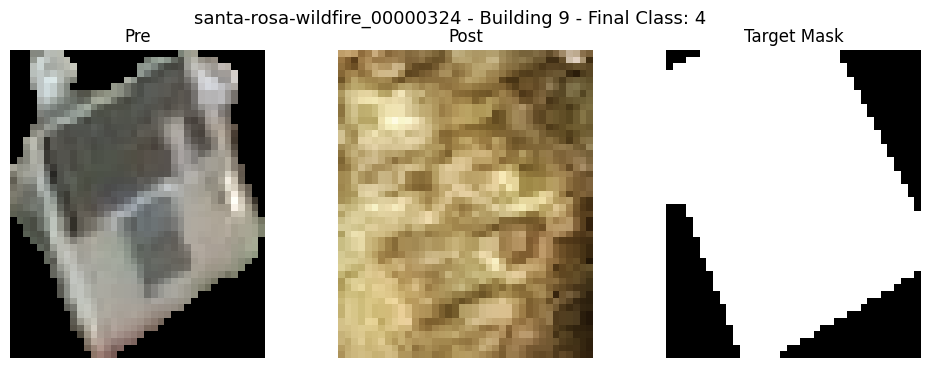


🧱 Image: santa-rosa-wildfire_00000324 | Building 10
📊 Pixel counts per class: {0: 913, 4: 1145}
📉 Class percentages: {0: 44.36, 4: 55.64}
✅ Final assigned damage class: 4


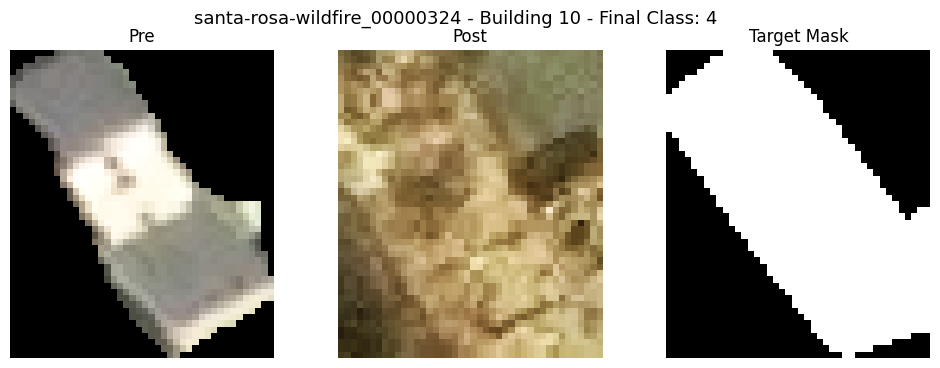


🧱 Image: santa-rosa-wildfire_00000324 | Building 11
📊 Pixel counts per class: {0: 790, 4: 2168}
📉 Class percentages: {0: 26.71, 4: 73.29}
✅ Final assigned damage class: 4


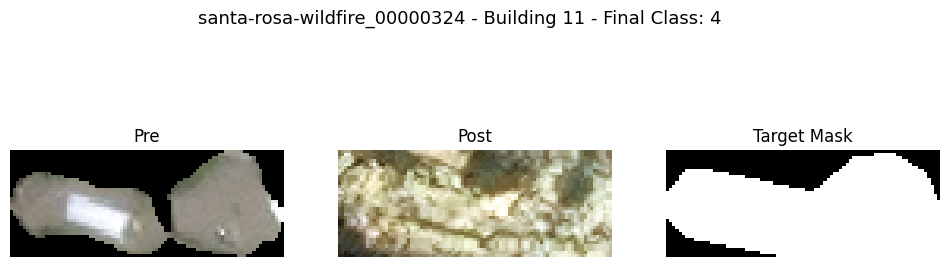


🧱 Image: santa-rosa-wildfire_00000324 | Building 12
📊 Pixel counts per class: {0: 7, 4: 323}
📉 Class percentages: {0: 2.12, 4: 97.88}
✅ Final assigned damage class: 4


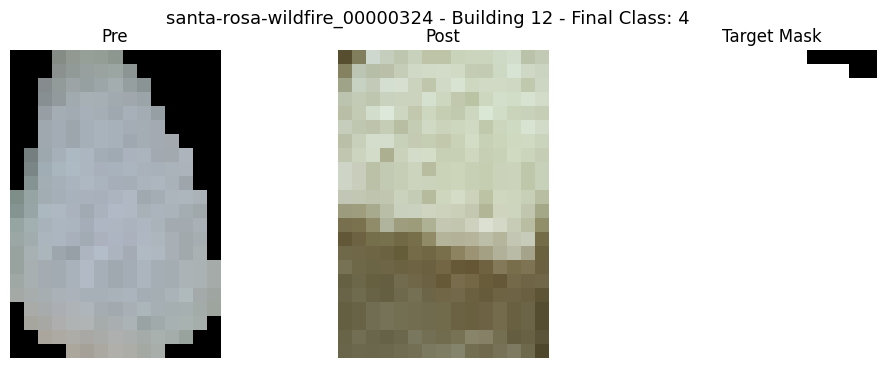

In [ ]:

import numpy as np
from PIL import Image
from patchify import patchify
from imantics import Mask
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import gc
import random

# --------------------- Full image prediction ---------------------
def model_predict_full_image(img_pre, model, patch_size=256, step=128):
    h, w = img_pre.shape[:2]
    pad_h = (patch_size - h % patch_size) % patch_size
    pad_w = (patch_size - w % patch_size) % patch_size

    img_pre_padded = np.pad(
        img_pre.astype(np.float32) / 255.0,
        ((0, pad_h), (0, pad_w), (0, 0)),
        mode="reflect"
    )

    patches = patchify(img_pre_padded, (patch_size, patch_size, 3), step=step)
    patches = patches[:, :, 0, :, :, :]
    n_h, n_w = patches.shape[:2]
    flat_patches = patches.reshape(-1, patch_size, patch_size, 3)

    preds_flat = model.predict(flat_patches, batch_size=4, verbose=0)
    if preds_flat.shape[-1] != 1:
        preds_flat = np.expand_dims(preds_flat[..., 0], axis=-1)

    prob_map = np.zeros((img_pre_padded.shape[0], img_pre_padded.shape[1]), dtype=np.float32)
    weight_map = np.zeros_like(prob_map)
    gx = np.linspace(-1, 1, patch_size)
    gw = np.exp(-0.5 * (gx ** 2) / 0.25 ** 2)
    gw2d = np.outer(gw, gw)

    idx = 0
    for i in range(n_h):
        for j in range(n_w):
            y0, x0 = i * step, j * step
            y1, x1 = y0 + patch_size, x0 + patch_size
            prob_map[y0:y1, x0:x1] += preds_flat[idx, ..., 0] * gw2d
            weight_map[y0:y1, x0:x1] += gw2d
            idx += 1

    weight_map[weight_map == 0] = 1.0
    y_pred_full = (prob_map / weight_map)[:h, :w]
    y_pred_bin = (y_pred_full > 0.9).astype(np.uint8)
    return y_pred_bin


# --------------------- Crop valid polygons safely ---------------------
def crop_polygon(img, poly):
    coords = np.array(poly)
    if coords.ndim == 1:
        coords = coords.reshape(-1, 2)
    if len(coords) < 3:
        return None
    coords = coords.astype(np.int32)

    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [coords], 1)
    x, y, w, h = cv2.boundingRect(coords)

    # Skip tiny polygons
    if w < 5 or h < 5:
        print(f"⚠️  Skipping tiny polygon (w={w}, h={h})")
        return None

    cropped = cv2.bitwise_and(img, img, mask=mask)
    return cropped[y:y+h, x:x+w], (x, y, w, h)


def plot_random_building(train_dict, model, bg_threshold=0.9, damage_threshold=0.05):
    img_id, info = random.choice(list(train_dict.items()))
    print(f"\n🧠 Debugging image: {img_id}")

    img_pre = np.array(Image.open(info['pre_image']).convert("RGB"))
    img_post = np.array(Image.open(info['post_image']).convert("RGB"))
    target_mask = np.array(Image.open(info['target_mask']))

    if img_pre.shape[:2] != target_mask.shape[:2]:
        target_mask = cv2.resize(target_mask, (img_pre.shape[1], img_pre.shape[0]), interpolation=cv2.INTER_NEAREST)

    # --- Predict binary mask ---
    y_pred_bin = model_predict_full_image(img_pre, model)
    print(f"Pred shape: {y_pred_bin.shape}, Pre shape: {img_pre.shape}")

    mask = Mask(y_pred_bin)
    polygons = mask.polygons().points
    print(f"Total predicted polygons: {len(polygons)}")

    # --- Overlay polygons on Pre & Mask ---
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_pre)
    plt.title("Predicted polygons on Pre-image")
    for poly in polygons:
        pts = np.array(poly)
        plt.plot(pts[:, 0], pts[:, 1], color='red', linewidth=1)

    plt.subplot(1, 2, 2)
    plt.imshow(target_mask, cmap='gray')
    plt.title("Predicted polygons on Target Mask")
    for poly in polygons:
        pts = np.array(poly)
        plt.plot(pts[:, 0], pts[:, 1], color='red', linewidth=1)
    plt.show()

    if len(polygons) == 0:
        print(f"No buildings predicted for {img_id}")
        return

    for idx, poly in enumerate(polygons):
        crop_result = crop_polygon(img_pre, poly)
        if crop_result is None:
            continue

        cropped_pre, bbox = crop_result
        x, y, w, h = bbox
        cropped_post = img_post[y:y+h, x:x+w]
        cropped_target = target_mask[y:y+h, x:x+w]

        building_pixels = cropped_target.flatten()
        total_pixels = len(building_pixels)
        unique, counts = np.unique(building_pixels, return_counts=True)
        class_distribution = dict(zip(unique, counts))
        class_percentages = {k: round(v / total_pixels * 100, 2) for k, v in class_distribution.items()}

        print(f"\n🧱 Image: {img_id} | Building {idx}")
        print(f"📊 Pixel counts per class: {class_distribution}")
        print(f"📉 Class percentages: {class_percentages}")

        # --- Background ratio ---
        bg_ratio = np.sum(building_pixels == 0) / total_pixels

        # --- Skip background-only crops ---
        if bg_ratio == 1.0:
            print(f"⚠️  Skipping building {idx}: only background pixels (likely false building).")
            continue

        # --- Ignore background when mixed ---
        non_bg_pixels = building_pixels[building_pixels > 0]
        if len(non_bg_pixels) == 0:
            print(f"⚠️  Skipping building {idx}: no valid damage pixels found.")
            continue

        # --- Compute ratio of damage vs background ---
        damage_ratio = len(non_bg_pixels) / total_pixels
        if damage_ratio < damage_threshold:
            print(f"⚠️  Skipping building {idx}: damage area too small ({damage_ratio*100:.2f}%).")
            continue

        # --- Determine dominant damage class (ignore background) ---
        counts = np.bincount(non_bg_pixels)
        dominant_class = np.argmax(counts)

        print(f"✅ Final assigned damage class: {dominant_class}")

        # --- Visualize ---
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"{img_id} - Building {idx} - Final Class: {dominant_class}", fontsize=13)
        plt.subplot(1, 3, 1)
        plt.imshow(cropped_pre)
        plt.title("Pre")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(cropped_post)
        plt.title("Post")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cropped_target, cmap='gray')
        plt.title("Target Mask")
        plt.axis('off')

        plt.show()

    del img_pre, img_post, target_mask, y_pred_bin, polygons
    gc.collect()
    tf.keras.backend.clear_session()
plot_random_building(train_dict, model)


## save the croped_bulinds with small area logic which use low resolution

In [ ]:
# import os
# import json
# import numpy as np
# from PIL import Image
# from patchify import patchify
# from imantics import Mask
# import cv2
# from tqdm import tqdm
# import tensorflow as tf
# import gc


# # --------------------- Full image prediction ---------------------
# def model_predict_full_image(img_pre, model, patch_size=256, step=128):
#     h, w = img_pre.shape[:2]
#     pad_h = (patch_size - h % patch_size) % patch_size
#     pad_w = (patch_size - w % patch_size) % patch_size

#     img_pre_padded = np.pad(
#         img_pre.astype(np.float32) / 255.0,
#         ((0, pad_h), (0, pad_w), (0, 0)),
#         mode="reflect"
#     )

#     patches = patchify(img_pre_padded, (patch_size, patch_size, 3), step=step)
#     patches = patches[:, :, 0, :, :, :]
#     n_h, n_w = patches.shape[:2]
#     flat_patches = patches.reshape(-1, patch_size, patch_size, 3)

#     preds_flat = model.predict(flat_patches, batch_size=4, verbose=0)
#     if preds_flat.shape[-1] != 1:
#         preds_flat = np.expand_dims(preds_flat[..., 0], axis=-1)

#     prob_map = np.zeros((img_pre_padded.shape[0], img_pre_padded.shape[1]), dtype=np.float32)
#     weight_map = np.zeros_like(prob_map)

#     gx = np.linspace(-1, 1, patch_size)
#     gw = np.exp(-0.5 * (gx ** 2) / 0.25 ** 2)
#     gw2d = np.outer(gw, gw)

#     idx = 0
#     for i in range(n_h):
#         for j in range(n_w):
#             y0, x0 = i * step, j * step
#             y1, x1 = y0 + patch_size, x0 + patch_size
#             prob_map[y0:y1, x0:x1] += preds_flat[idx, ..., 0] * gw2d
#             weight_map[y0:y1, x0:x1] += gw2d
#             idx += 1

#     weight_map[weight_map == 0] = 1.0
#     y_pred_full = (prob_map / weight_map)[:h, :w]
#     y_pred_bin = (y_pred_full > 0.8).astype(np.uint8)
#     return y_pred_bin


# # --------------------- Crop valid polygons safely ---------------------
# def crop_polygon(img, poly):
#     coords = np.array(poly)
#     if coords.ndim == 1:
#         coords = coords.reshape(-1, 2)
#     if len(coords) < 3:
#         return None
#     coords = coords.astype(np.int32)

#     mask = np.zeros(img.shape[:2], dtype=np.uint8)
#     cv2.fillPoly(mask, [coords], 1)
#     x, y, w, h = cv2.boundingRect(coords)

#     # Skip tiny polygons
#     if w < 5 or h < 5:
#         return None

#     cropped = cv2.bitwise_and(img, img, mask=mask)
#     return cropped[y:y+h, x:x+w], (x, y, w, h)


# # --------------------- Crop and Save All Valid Buildings ---------------------
# def save_cropped_buildings(train_dict, model, save_dir="/content/drive/MyDrive/cropped_buildings",
#                            bg_threshold=0.9, damage_threshold=0.05):

#     os.makedirs(save_dir, exist_ok=True)
#     all_crops = {}

#     for img_id, info in tqdm(train_dict.items(), desc="Processing images"):
#         img_pre = np.array(Image.open(info['pre_image']).convert("RGB"))
#         img_post = np.array(Image.open(info['post_image']).convert("RGB"))
#         target_mask = np.array(Image.open(info['target_mask']))

#         # Match shape
#         if img_pre.shape[:2] != target_mask.shape[:2]:
#             target_mask = cv2.resize(target_mask, (img_pre.shape[1], img_pre.shape[0]), interpolation=cv2.INTER_NEAREST)

#         # Predict building mask
#         y_pred_bin = model_predict_full_image(img_pre, model)
#         polygons = Mask(y_pred_bin).polygons().points

#         img_crops = {}
#         building_idx = 0

#         for poly in polygons:
#             crop_result = crop_polygon(img_pre, poly)
#             if crop_result is None:
#                 continue

#             cropped_pre, bbox = crop_result
#             x, y, w, h = bbox
#             cropped_post = img_post[y:y+h, x:x+w]
#             cropped_target = target_mask[y:y+h, x:x+w]

#             building_pixels = cropped_target.flatten()
#             total_pixels = len(building_pixels)

#             # Background check
#             bg_ratio = np.sum(building_pixels == 0) / total_pixels
#             if bg_ratio >= bg_threshold:
#                 continue

#             non_bg_pixels = building_pixels[building_pixels > 0]
#             if len(non_bg_pixels) == 0:
#                 continue

#             damage_ratio = len(non_bg_pixels) / total_pixels
#             if damage_ratio < damage_threshold:
#                 continue

#             # Dominant class
#             counts = np.bincount(non_bg_pixels)
#             dominant_class = np.argmax(counts)

#             # --- Save crops ---
#             pre_path = os.path.join(save_dir, f"{img_id}_building_{building_idx}_pre.png")
#             post_path = os.path.join(save_dir, f"{img_id}_building_{building_idx}_post.png")

#             Image.fromarray(cropped_pre).save(pre_path)
#             Image.fromarray(cropped_post).save(post_path)

#             img_crops[building_idx] = {
#                 "pre": pre_path,
#                 "post": post_path,
#                 "label": int(dominant_class)
#             }

#             building_idx += 1

#         if img_crops:
#             all_crops[img_id] = img_crops

#         del img_pre, img_post, target_mask, y_pred_bin, polygons
#         gc.collect()
#         tf.keras.backend.clear_session()

#     # --- Save metadata as JSON ---
#     json_path = os.path.join(save_dir, "cropped_buildings_metadata.json")
#     with open(json_path, "w") as f:
#         json.dump(all_crops, f, indent=4)

#     print(f"\n✅ Cropping completed. Metadata saved to: {json_path}")
#     return all_crops

# cropped_data = save_cropped_buildings(
#     train_dict=train_dict,model=model,
#     save_dir="/content/drive/MyDrive/croped_pre_post_bulinding",  # your save path
#     bg_threshold=0.9,   # skip crops that are mostly background
#     damage_threshold=0.05  # skip crops with too little damaged area
# )


# print(f"\nTotal images with cropped buildings: {len(cropped_data)}")


Processing images: 100%|██████████| 140/140 [10:09<00:00,  4.35s/it]


✅ Cropping completed. Metadata saved to: /content/drive/MyDrive/croped_pre_post_bulinding/cropped_buildings_metadata.json

Total images with cropped buildings: 116


# load data

In [ ]:
import os
import json

def load_cropped_building_paths(save_dir="/content/drive/MyDrive/croped_pre_post_bulinding"):
    """
    Load pre/post image paths and labels from saved metadata JSON.
    Does NOT load image arrays into memory — only returns file paths and labels.
    """
    json_path = os.path.join(save_dir, "cropped_buildings_metadata.json")

    if not os.path.exists(json_path):
        raise FileNotFoundError(f"Metadata JSON not found: {json_path}")

    with open(json_path, "r") as f:
        all_crops = json.load(f)

    loaded_paths = {}

    for img_id, buildings in all_crops.items():
        loaded_paths[img_id] = {}
        for b_id, data in buildings.items():
            pre_path = data["pre"]
            post_path = data["post"]
            label = data["label"]

            # verify paths exist
            if os.path.exists(pre_path) and os.path.exists(post_path):
                loaded_paths[img_id][b_id] = {
                    "pre_path": pre_path,
                    "post_path": post_path,
                    "label": label
                }
            else:
                print(f"⚠️ Missing file for {img_id} | Building {b_id}, skipping.")

    print(f"\n✅ Loaded {len(loaded_paths)} images with cropped building path data.")
    return loaded_paths


In [ ]:
save_dir = "/content/drive/MyDrive/croped_pre_post_bulinding"
data_paths = load_cropped_building_paths(save_dir)


✅ Loaded 116 images with cropped building path data.


In [ ]:
pprint(dict(list(data_paths.items())[44:47]))

{'santa-rosa-wildfire_00000191': {'0': {'label': 4,
                                        'post_path': '/content/drive/MyDrive/croped_pre_post_bulinding/santa-rosa-wildfire_00000191_building_0_post.png',
                                        'pre_path': '/content/drive/MyDrive/croped_pre_post_bulinding/santa-rosa-wildfire_00000191_building_0_pre.png'},
                                  '1': {'label': 4,
                                        'post_path': '/content/drive/MyDrive/croped_pre_post_bulinding/santa-rosa-wildfire_00000191_building_1_post.png',
                                        'pre_path': '/content/drive/MyDrive/croped_pre_post_bulinding/santa-rosa-wildfire_00000191_building_1_pre.png'},
                                  '2': {'label': 4,
                                        'post_path': '/content/drive/MyDrive/croped_pre_post_bulinding/santa-rosa-wildfire_00000191_building_2_post.png',
                                        'pre_path': '/content/drive/MyDrive/

# visualize the loaded croped images

/tmp/ipython-input-715668194.py:46: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


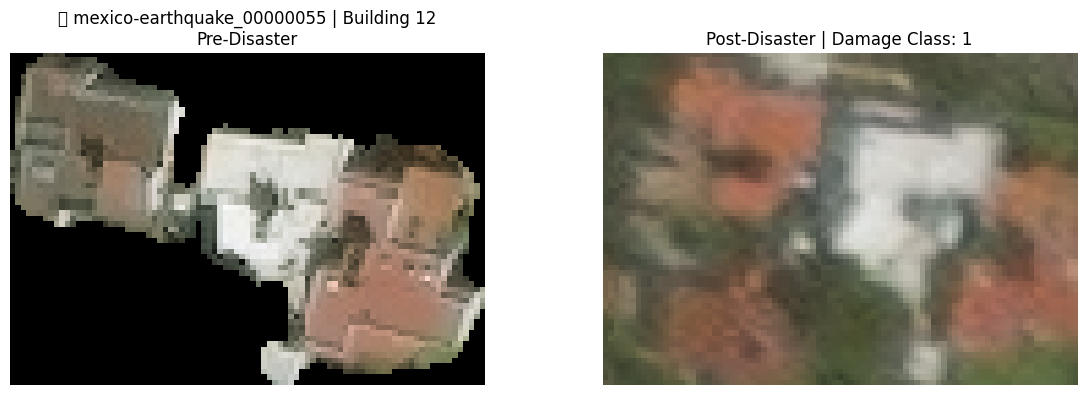

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random

def plot_pre_post_samples(paths_dict, n_samples=3):
    """
    Randomly plots a few pre/post image pairs with their damage labels
    from the cropped dataset.
    """
    # Collect all (img_id, building_id, data) tuples
    all_buildings = [
        (img_id, b_id, data)
        for img_id, buildings in paths_dict.items()
        for b_id, data in buildings.items()
    ]

    # Shuffle for randomness
    random.shuffle(all_buildings)

    # Pick N samples
    samples = all_buildings[:n_samples]

    # Plot
    plt.figure(figsize=(12, n_samples * 4))

    for idx, (img_id, b_id, data) in enumerate(samples, 1):
        pre_path = data['pre_path']
        post_path = data['post_path']
        label = data['label']

        pre_img = Image.open(pre_path)
        post_img = Image.open(post_path)

        # Pre
        plt.subplot(n_samples, 2, (idx - 1) * 2 + 1)
        plt.imshow(pre_img)
        plt.axis("off")
        plt.title(f"🧱 {img_id} | Building {b_id}\nPre-Disaster")

        # Post
        plt.subplot(n_samples, 2, (idx - 1) * 2 + 2)
        plt.imshow(post_img)
        plt.axis("off")
        plt.title(f"Post-Disaster | Damage Class: {label}")

    plt.tight_layout()
    plt.show()
plot_pre_post_samples(data_paths, n_samples=1)

# improved dataset for the damage_classification


🧩 Debugging image: hurricane-florence_00000180
Pred shape: (1024, 1024), Pre shape: (1024, 1024, 3)
Total predicted polygons: 2


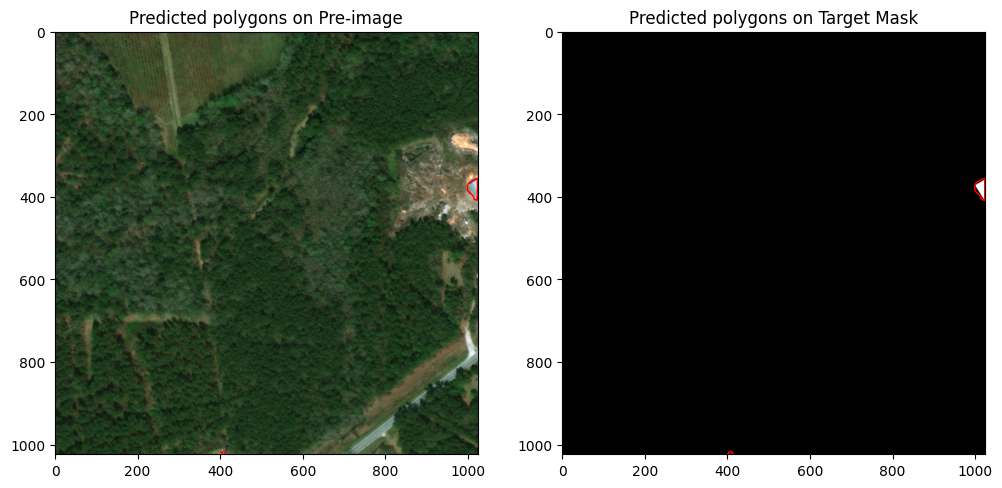

⚠️  Skipping polygon: w=12, h=7, ratio=1.71
⚠️  Skipping polygon: w=25, h=54, ratio=0.46


In [ ]:
import numpy as np
from PIL import Image
from patchify import patchify
from imantics import Mask
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import gc
import random

# --------------------- Full image prediction ---------------------
def model_predict_full_image(img_pre, model, patch_size=256, step=128):
    h, w = img_pre.shape[:2]
    pad_h = (patch_size - h % patch_size) % patch_size
    pad_w = (patch_size - w % patch_size) % patch_size

    img_pre_padded = np.pad(
        img_pre.astype(np.float32) / 255.0,
        ((0, pad_h), (0, pad_w), (0, 0)),
        mode="reflect"
    )

    patches = patchify(img_pre_padded, (patch_size, patch_size, 3), step=step)
    patches = patches[:, :, 0, :, :, :]
    n_h, n_w = patches.shape[:2]
    flat_patches = patches.reshape(-1, patch_size, patch_size, 3)

    preds_flat = model.predict(flat_patches, batch_size=4, verbose=0)
    if preds_flat.shape[-1] != 1:
        preds_flat = np.expand_dims(preds_flat[..., 0], axis=-1)

    prob_map = np.zeros((img_pre_padded.shape[0], img_pre_padded.shape[1]), dtype=np.float32)
    weight_map = np.zeros_like(prob_map)
    gx = np.linspace(-1, 1, patch_size)
    gw = np.exp(-0.5 * (gx ** 2) / 0.25 ** 2)
    gw2d = np.outer(gw, gw)

    idx = 0
    for i in range(n_h):
        for j in range(n_w):
            y0, x0 = i * step, j * step
            y1, x1 = y0 + patch_size, x0 + patch_size
            prob_map[y0:y1, x0:x1] += preds_flat[idx, ..., 0] * gw2d
            weight_map[y0:y1, x0:x1] += gw2d
            idx += 1

    weight_map[weight_map == 0] = 1.0
    y_pred_full = (prob_map / weight_map)[:h, :w]
    y_pred_bin = (y_pred_full > 0.9).astype(np.uint8)

    # --- Morphological closing & dilation (expand predicted buildings) ---
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    y_pred_bin = cv2.morphologyEx(y_pred_bin, cv2.MORPH_CLOSE, kernel)
    y_pred_bin = cv2.dilate(y_pred_bin, kernel, iterations=2)  # 🔹 expand building slightly

    return y_pred_bin


# --------------------- Crop valid polygons safely ---------------------
# def crop_polygon(img_pre, img_post, target_mask, poly):
#     coords = np.array(poly)
#     if coords.ndim == 1:
#         coords = coords.reshape(-1, 2)
#     if len(coords) < 3:
#         return None
#     coords = coords.astype(np.int32)

#     mask = np.zeros(img_pre.shape[:2], dtype=np.uint8)
#     cv2.fillPoly(mask, [coords], 1)
#     x, y, w, h = cv2.boundingRect(coords)

#     # Skip tiny or extreme shapes
#     aspect_ratio = w / h if h != 0 else 0
#     if w < 37 or h < 37 or aspect_ratio < 0.2 or aspect_ratio > 5.0:
#         print(f"⚠️  Skipping polygon: w={w}, h={h}, ratio={aspect_ratio:.2f}")
#         return None

#     # Apply same crop to pre, post, and target mask
#     cropped_pre = cv2.bitwise_and(img_pre, img_pre, mask=mask)[y:y+h, x:x+w]
#     cropped_post = cv2.bitwise_and(img_post, img_post, mask=mask)[y:y+h, x:x+w]
#     cropped_target = target_mask[y:y+h, x:x+w]

#     return cropped_pre, cropped_post, cropped_target, (x, y, w, h)


def crop_polygon(img_pre, img_post, target_mask, poly):
    coords = np.array(poly)
    if coords.ndim == 1:
        coords = coords.reshape(-1, 2)
    if len(coords) < 3:
        return None
    coords = coords.astype(np.int32)

    mask = np.zeros(img_pre.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [coords], 1)
    x, y, w, h = cv2.boundingRect(coords)

    # 🔹 Add small padding (5 pixels around)
    # x1 = max(0, x - 5)
    # y1 = max(0, y - 5)
    # x2 = min(img_pre.shape[1], x + w + 50)
    # y2 = min(img_pre.shape[0], y + h + 50)

    pad = int(0.1 * max(w, h))  # 10% of building size
    x1 = max(0, x - pad)
    y1 = max(0, y - pad)
    x2 = min(img_pre.shape[1], x + w + pad)
    y2 = min(img_pre.shape[0], y + h + pad)

    # Skip tiny or extreme shapes
    aspect_ratio = w / h if h != 0 else 0
    if w < 37 or h < 37 or aspect_ratio < 0.2 or aspect_ratio > 5.0:
        print(f"⚠️  Skipping polygon: w={w}, h={h}, ratio={aspect_ratio:.2f}")
        return None

    # Apply same crop to pre, post, and target mask
    cropped_pre = cv2.bitwise_and(img_pre, img_pre, mask=mask)[y1:y2, x1:x2]
    cropped_post = cv2.bitwise_and(img_post, img_post, mask=mask)[y1:y2, x1:x2]
    cropped_target = target_mask[y1:y2, x1:x2]

    return cropped_pre, cropped_post, cropped_target, (x1, y1, x2 - x1, y2 - y1)



# --------------------- Random sample visualization ---------------------
def plot_random_building(train_dict, model, bg_threshold=0.9, damage_threshold=0.05, dominant_threshold=0.6):
    img_id, info = random.choice(list(train_dict.items()))
    print(f"\n🧩 Debugging image: {img_id}")

    img_pre = np.array(Image.open(info['pre_image']).convert("RGB"))
    img_post = np.array(Image.open(info['post_image']).convert("RGB"))
    target_mask = np.array(Image.open(info['target_mask']))

    if img_pre.shape[:2] != target_mask.shape[:2]:
        target_mask = cv2.resize(target_mask, (img_pre.shape[1], img_pre.shape[0]), interpolation=cv2.INTER_NEAREST)

    # --- Predict binary mask ---
    y_pred_bin = model_predict_full_image(img_pre, model)
    print(f"Pred shape: {y_pred_bin.shape}, Pre shape: {img_pre.shape}")

    mask = Mask(y_pred_bin)
    polygons = mask.polygons().points
    print(f"Total predicted polygons: {len(polygons)}")

    # --- Overlay polygons ---
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_pre)
    plt.title("Predicted polygons on Pre-image")
    for poly in polygons:
        pts = np.array(poly)
        plt.plot(pts[:, 0], pts[:, 1], color='red', linewidth=1)

    plt.subplot(1, 2, 2)
    plt.imshow(target_mask, cmap='gray')
    plt.title("Predicted polygons on Target Mask")
    for poly in polygons:
        pts = np.array(poly)
        plt.plot(pts[:, 0], pts[:, 1], color='red', linewidth=1)
    plt.show()

    if len(polygons) == 0:
        print(f"No buildings predicted for {img_id}")
        return

    # --- Process each predicted building ---
    for idx, poly in enumerate(polygons):
        result = crop_polygon(img_pre, img_post, target_mask, poly)
        if result is None:
            continue

        cropped_pre, cropped_post, cropped_target, bbox = result
        x, y, w, h = bbox

        # --- Resize pre and post images for consistency (e.g., for classification input) ---
        # cropped_pre_resized = cv2.resize(cropped_pre, (224, 224))
        # cropped_post_resized = cv2.resize(cropped_post, (224, 224))

        cropped_pre_resized = cv2.resize(cropped_pre, (224, 224), interpolation=cv2.INTER_CUBIC)
        cropped_post_resized = cv2.resize(cropped_post, (224, 224), interpolation=cv2.INTER_CUBIC)

        kernel_sharpen = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
        cropped_pre_resized = cv2.filter2D(cropped_pre_resized, -1, kernel_sharpen)
        cropped_post_resized = cv2.filter2D(cropped_post_resized, -1, kernel_sharpen)



        building_pixels = cropped_target.flatten()
        total_pixels = len(building_pixels)
        unique, counts = np.unique(building_pixels, return_counts=True)
        class_distribution = dict(zip(unique, counts))
        class_percentages = {k: round(v / total_pixels * 100, 2) for k, v in class_distribution.items()}

        print(f"\n🧱 Image: {img_id} | Building {idx}")
        print(f"📊 Pixel counts per class: {class_distribution}")
        print(f"📉 Class percentages: {class_percentages}")

        # --- Background ratio ---
        bg_ratio = np.sum(building_pixels == 0) / total_pixels
        if bg_ratio >= bg_threshold:
            print(f"⚠️ Skipping building {idx}: mostly background ({bg_ratio:.2f}).")
            continue

        non_bg_pixels = building_pixels[building_pixels > 0]
        if len(non_bg_pixels) == 0:
            print(f"⚠️ Skipping building {idx}: no damage pixels.")
            continue

        damage_ratio = len(non_bg_pixels) / total_pixels
        if damage_ratio < damage_threshold:
            print(f"⚠️ Skipping building {idx}: damage area too small ({damage_ratio*100:.2f}%).")
            continue

        counts = np.bincount(non_bg_pixels)
        dominant_class = np.argmax(counts)
        dominant_ratio = counts[dominant_class] / np.sum(counts)

        if dominant_ratio < dominant_threshold:
            print(f"⚠️ Skipping building {idx}: No dominant class ({dominant_ratio*100:.2f}%).")
            continue

        print(f"✅ Final assigned damage class: {dominant_class} ({dominant_ratio*100:.2f}% dominance)")

        # --- Visualize ---
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"{img_id} - Building {idx} - Class: {dominant_class} ({dominant_ratio*100:.1f}%)", fontsize=13)
        plt.subplot(1, 3, 1)
        plt.imshow(cropped_pre_resized)
        plt.title("Pre")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(cropped_post_resized)
        plt.title("Post")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cropped_target, cmap='gray')
        plt.title("Target Mask")
        plt.axis('off')

        plt.show()

    del img_pre, img_post, target_mask, y_pred_bin, polygons
    gc.collect()
    tf.keras.backend.clear_session()


# --------------------- Run ---------------------
plot_random_building(train_dict, model, bg_threshold=0.9, damage_threshold=0.05, dominant_threshold=0.6)


# with iou


 Debugging image: hurricane-harvey_00000270
Pred shape: (1024, 1024), Pre shape: (1024, 1024, 3)
Total predicted polygons: 1


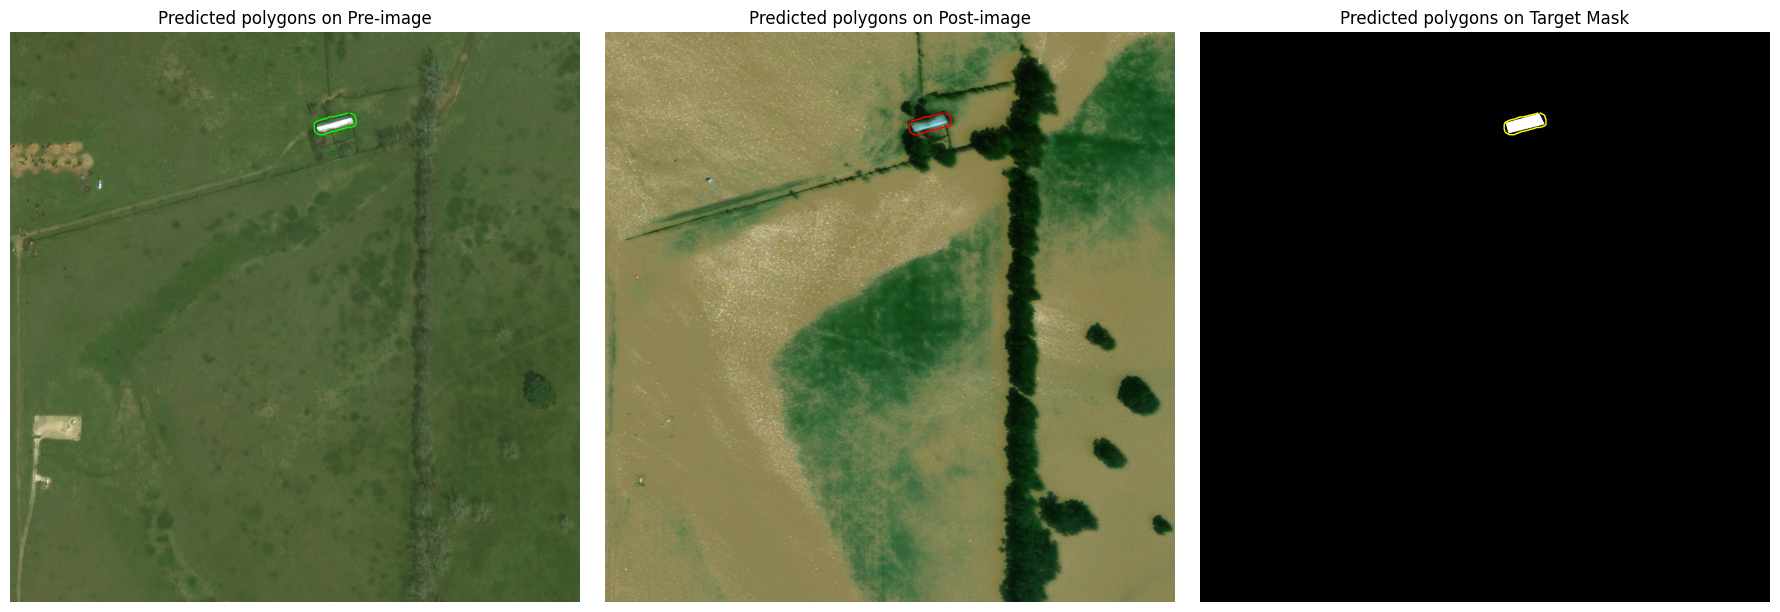

✅ Building 0 IoU passed: 0.69

 Image: hurricane-harvey_00000270 | Building 0
 Pixel counts per class: {0: 6068, 2: 1352}
 Class percentages: {0: 81.78, 2: 18.22}
 Final assigned damage class: 2 (100.00% dominance)


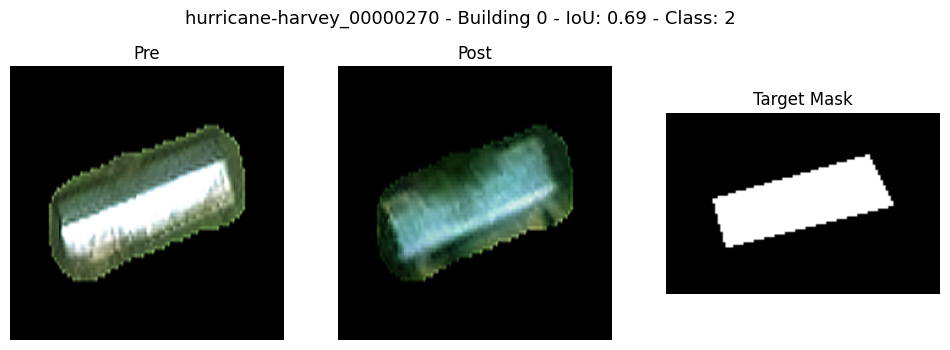

In [ ]:
import numpy as np
from PIL import Image
from patchify import patchify
from imantics import Mask
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import gc
import random

# --------------------- Full image prediction ---------------------
def model_predict_full_image(img_pre, model, patch_size=256, step=128):
    h, w = img_pre.shape[:2]
    pad_h = (patch_size - h % patch_size) % patch_size
    pad_w = (patch_size - w % patch_size) % patch_size

    img_pre_padded = np.pad(
        img_pre.astype(np.float32) / 255.0,
        ((0, pad_h), (0, pad_w), (0, 0)),
        mode="reflect"
    )

    patches = patchify(img_pre_padded, (patch_size, patch_size, 3), step=step)
    patches = patches[:, :, 0, :, :, :]
    n_h, n_w = patches.shape[:2]
    flat_patches = patches.reshape(-1, patch_size, patch_size, 3)

    preds_flat = model.predict(flat_patches, batch_size=4, verbose=0)
    if preds_flat.shape[-1] != 1:
        preds_flat = np.expand_dims(preds_flat[..., 0], axis=-1)

    prob_map = np.zeros((img_pre_padded.shape[0], img_pre_padded.shape[1]), dtype=np.float32)
    weight_map = np.zeros_like(prob_map)
    gx = np.linspace(-1, 1, patch_size)
    gw = np.exp(-0.5 * (gx ** 2) / 0.25 ** 2)
    gw2d = np.outer(gw, gw)

    idx = 0
    for i in range(n_h):
        for j in range(n_w):
            y0, x0 = i * step, j * step
            y1, x1 = y0 + patch_size, x0 + patch_size
            prob_map[y0:y1, x0:x1] += preds_flat[idx, ..., 0] * gw2d
            weight_map[y0:y1, x0:x1] += gw2d
            idx += 1

    weight_map[weight_map == 0] = 1.0
    y_pred_full = (prob_map / weight_map)[:h, :w]
    y_pred_bin = (y_pred_full > 0.9).astype(np.uint8)

    # --- Morphological closing & dilation (expand predicted buildings) ---
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    y_pred_bin = cv2.morphologyEx(y_pred_bin, cv2.MORPH_CLOSE, kernel)
    y_pred_bin = cv2.dilate(y_pred_bin, kernel, iterations=2)  # 🔹 expand building slightly

    return y_pred_bin


# --------------------- Crop valid polygons safely ---------------------
# def crop_polygon(img_pre, img_post, target_mask, poly):
#     coords = np.array(poly)
#     if coords.ndim == 1:
#         coords = coords.reshape(-1, 2)
#     if len(coords) < 3:
#         return None
#     coords = coords.astype(np.int32)

#     mask = np.zeros(img_pre.shape[:2], dtype=np.uint8)
#     cv2.fillPoly(mask, [coords], 1)
#     x, y, w, h = cv2.boundingRect(coords)

#     # Skip tiny or extreme shapes
#     aspect_ratio = w / h if h != 0 else 0
#     if w < 37 or h < 37 or aspect_ratio < 0.2 or aspect_ratio > 5.0:
#         print(f"⚠️  Skipping polygon: w={w}, h={h}, ratio={aspect_ratio:.2f}")
#         return None

#     # Apply same crop to pre, post, and target mask
#     cropped_pre = cv2.bitwise_and(img_pre, img_pre, mask=mask)[y:y+h, x:x+w]
#     cropped_post = cv2.bitwise_and(img_post, img_post, mask=mask)[y:y+h, x:x+w]
#     cropped_target = target_mask[y:y+h, x:x+w]

#     return cropped_pre, cropped_post, cropped_target, (x, y, w, h)


def crop_polygon(img_pre, img_post, target_mask, poly):
    coords = np.array(poly)
    if coords.ndim == 1:
        coords = coords.reshape(-1, 2)
    if len(coords) < 3:
        return None
    coords = coords.astype(np.int32)

    mask = np.zeros(img_pre.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [coords], 1)
    x, y, w, h = cv2.boundingRect(coords)

    # 🔹 Add small padding (5 pixels around)
    # x1 = max(0, x - 5)
    # y1 = max(0, y - 5)
    # x2 = min(img_pre.shape[1], x + w + 50)
    # y2 = min(img_pre.shape[0], y + h + 50)

    pad = int(0.2 * max(w, h))  # 10% of building size
    x1 = max(0, x - pad)
    y1 = max(0, y - pad)
    x2 = min(img_pre.shape[1], x + w + pad)
    y2 = min(img_pre.shape[0], y + h + pad)

    # Skip tiny or extreme shapes
    aspect_ratio = w / h if h != 0 else 0
    if w < 25 or h < 25 or aspect_ratio < 0.4 or aspect_ratio > 3.0:
        print(f"⚠️  Skipping polygon: w={w}, h={h}, ratio={aspect_ratio:.2f}")
        return None

    # Apply same crop to pre, post, and target mask
    cropped_pre = cv2.bitwise_and(img_pre, img_pre, mask=mask)[y1:y2, x1:x2]
    cropped_post = cv2.bitwise_and(img_post, img_post, mask=mask)[y1:y2, x1:x2]
    cropped_target = target_mask[y1:y2, x1:x2]

    return cropped_pre, cropped_post, cropped_target, (x1, y1, x2 - x1, y2 - y1)



# --------------------- Random sample visualization ---------------------
def plot_random_building(train_dict, model, bg_threshold=0.9, damage_threshold=0.05, dominant_threshold=0.6, iou_threshold=0.65):
    img_id, info = random.choice(list(train_dict.items()))
    print(f"\n Debugging image: {img_id}")

    img_pre = np.array(Image.open(info['pre_image']).convert("RGB"))
    img_post = np.array(Image.open(info['post_image']).convert("RGB"))
    target_mask = np.array(Image.open(info['target_mask']))

    if img_pre.shape[:2] != target_mask.shape[:2]:
        target_mask = cv2.resize(target_mask, (img_pre.shape[1], img_pre.shape[0]), interpolation=cv2.INTER_NEAREST)

    # --- Predict binary mask ---
    y_pred_bin = model_predict_full_image(img_pre, model)
    print(f"Pred shape: {y_pred_bin.shape}, Pre shape: {img_pre.shape}")

    mask = Mask(y_pred_bin)
    polygons = mask.polygons().points
    print(f"Total predicted polygons: {len(polygons)}")

    # --- Overlay polygons ---
    # --- Overlay polygons on Pre, Post, and Target ---
    plt.figure(figsize=(18, 6))

    #  Pre-image with predicted polygons
    plt.subplot(1, 3, 1)
    plt.imshow(img_pre)
    plt.title("Predicted polygons on Pre-image")
    for poly in polygons:
        pts = np.array(poly)
        plt.plot(pts[:, 0], pts[:, 1], color='lime', linewidth=1)
    plt.axis("off")

    #  Post-image with same polygons
    plt.subplot(1, 3, 2)
    plt.imshow(img_post)
    plt.title("Predicted polygons on Post-image")
    for poly in polygons:
        pts = np.array(poly)
        plt.plot(pts[:, 0], pts[:, 1], color='red', linewidth=1)
    plt.axis("off")

    #  Target mask overlay for reference
    plt.subplot(1, 3, 3)
    plt.imshow(target_mask, cmap='gray')
    plt.title("Predicted polygons on Target Mask")
    for poly in polygons:
        pts = np.array(poly)
        plt.plot(pts[:, 0], pts[:, 1], color='yellow', linewidth=1)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


    if len(polygons) == 0:
        print(f"No buildings predicted for {img_id}")
        return

    # --- Process each predicted building ---
    for idx, poly in enumerate(polygons):
        result = crop_polygon(img_pre, img_post, target_mask, poly)
        if result is None:
            continue

        cropped_pre, cropped_post, cropped_target, bbox = result
        x, y, w, h = bbox

        # ---------------- IoU Calculation ----------------
        # Create a full-size mask for this polygon
        poly_mask = np.zeros(img_pre.shape[:2], dtype=np.uint8)
        coords = np.array(poly).astype(np.int32)
        if coords.ndim == 1:
            coords = coords.reshape(-1, 2)
        cv2.fillPoly(poly_mask, [coords], 1)

        # Crop predicted mask and GT binary mask in same region
        y1, y2 = y, y + h
        x1, x2 = x, x + w
        pred_crop = poly_mask[y1:y2, x1:x2]
        gt_crop = (target_mask[y1:y2, x1:x2] > 0).astype(np.uint8)

        intersection = np.logical_and(pred_crop, gt_crop).sum()
        union = np.logical_or(pred_crop, gt_crop).sum()
        iou = intersection / union if union > 0 else 0.0

        if iou < iou_threshold:
            print(f"⚠️ Skipping building {idx}: IoU too low ({iou:.2f} < {iou_threshold}).")
            continue
        else:
            print(f"✅ Building {idx} IoU passed: {iou:.2f}")

        # --------------------------------------------------

        cropped_pre_resized = cv2.resize(cropped_pre, (224, 224), interpolation=cv2.INTER_CUBIC)
        cropped_post_resized = cv2.resize(cropped_post, (224, 224), interpolation=cv2.INTER_CUBIC)

        kernel_sharpen = np.array([[0, -1, 0],
                                   [-1, 5, -1],
                                   [0, -1, 0]])
        cropped_pre_resized = cv2.filter2D(cropped_pre_resized, -1, kernel_sharpen)
        cropped_post_resized = cv2.filter2D(cropped_post_resized, -1, kernel_sharpen)

        building_pixels = cropped_target.flatten()
        total_pixels = len(building_pixels)
        unique, counts = np.unique(building_pixels, return_counts=True)
        class_distribution = dict(zip(unique, counts))
        class_percentages = {k: round(v / total_pixels * 100, 2) for k, v in class_distribution.items()}

        print(f"\n Image: {img_id} | Building {idx}")
        print(f" Pixel counts per class: {class_distribution}")
        print(f" Class percentages: {class_percentages}")

        bg_ratio = np.sum(building_pixels == 0) / total_pixels
        if bg_ratio >= bg_threshold:
            print(f"⚠️ Skipping building {idx}: mostly background ({bg_ratio:.2f}).")
            continue

        non_bg_pixels = building_pixels[building_pixels > 0]
        if len(non_bg_pixels) == 0:
            print(f"⚠️ Skipping building {idx}: no damage pixels.")
            continue

        damage_ratio = len(non_bg_pixels) / total_pixels
        if damage_ratio < damage_threshold:
            print(f"⚠️ Skipping building {idx}: damage area too small ({damage_ratio*100:.2f}%).")
            continue

        counts = np.bincount(non_bg_pixels)
        dominant_class = np.argmax(counts)
        dominant_ratio = counts[dominant_class] / np.sum(counts)

        if dominant_ratio < dominant_threshold:
            print(f"⚠️ Skipping building {idx}: No dominant class ({dominant_ratio*100:.2f}%).")
            continue

        print(f" Final assigned damage class: {dominant_class} ({dominant_ratio*100:.2f}% dominance)")

        # --- Visualize ---
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"{img_id} - Building {idx} - IoU: {iou:.2f} - Class: {dominant_class}", fontsize=13)
        plt.subplot(1, 3, 1)
        plt.imshow(cropped_pre_resized)
        plt.title("Pre")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(cropped_post_resized)
        plt.title("Post")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cropped_target, cmap='gray')
        plt.title("Target Mask")
        plt.axis('off')

        plt.show()

    del img_pre, img_post, target_mask, y_pred_bin, polygons
    gc.collect()
    tf.keras.backend.clear_session()


# --------------------- Run ---------------------
plot_random_building(train_dict, model, bg_threshold=0.9, damage_threshold=0.05, dominant_threshold=0.7)


### just improved crops with 0.15 background for leaning the context not shape

In [ ]:
import numpy as np
from PIL import Image
from patchify import patchify
from imantics import Mask
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import gc
import random

# --------------------- Full image prediction ---------------------
def model_predict_full_image(img_pre, model, patch_size=256, step=128):
    h, w = img_pre.shape[:2]
    pad_h = (patch_size - h % patch_size) % patch_size
    pad_w = (patch_size - w % patch_size) % patch_size

    img_pre_padded = np.pad(
        img_pre.astype(np.float32) / 255.0,
        ((0, pad_h), (0, pad_w), (0, 0)),
        mode="reflect"
    )

    patches = patchify(img_pre_padded, (patch_size, patch_size, 3), step=step)
    patches = patches[:, :, 0, :, :, :]
    n_h, n_w = patches.shape[:2]
    flat_patches = patches.reshape(-1, patch_size, patch_size, 3)

    preds_flat = model.predict(flat_patches, batch_size=4, verbose=0)
    if preds_flat.shape[-1] != 1:
        preds_flat = np.expand_dims(preds_flat[..., 0], axis=-1)

    prob_map = np.zeros((img_pre_padded.shape[0], img_pre_padded.shape[1]), dtype=np.float32)
    weight_map = np.zeros_like(prob_map)
    gx = np.linspace(-1, 1, patch_size)
    gw = np.exp(-0.5 * (gx ** 2) / 0.25 ** 2)
    gw2d = np.outer(gw, gw)

    idx = 0
    for i in range(n_h):
        for j in range(n_w):
            y0, x0 = i * step, j * step
            y1, x1 = y0 + patch_size, x0 + patch_size
            prob_map[y0:y1, x0:x1] += preds_flat[idx, ..., 0] * gw2d
            weight_map[y0:y1, x0:x1] += gw2d
            idx += 1

    weight_map[weight_map == 0] = 1.0
    y_pred_full = (prob_map / weight_map)[:h, :w]
    y_pred_bin = (y_pred_full > 0.9).astype(np.uint8)

    # --- Morphological refinement ---
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    y_pred_bin = cv2.morphologyEx(y_pred_bin, cv2.MORPH_CLOSE, kernel)
    y_pred_bin = cv2.dilate(y_pred_bin, kernel, iterations=2)

    return y_pred_bin


# --------------------- Bounding Box Cropping (with context) ---------------------
def crop_polygon_with_context(img_pre, img_post, target_mask, poly, pad_ratio=0.15):
    coords = np.array(poly, dtype=np.int32)
    if coords.ndim == 1:
        coords = coords.reshape(-1, 2)
    if len(coords) < 3:
        return None

    x, y, w, h = cv2.boundingRect(coords)
    pad = int(pad_ratio * max(w, h))

    x1 = max(0, x - pad)
    y1 = max(0, y - pad)
    x2 = min(img_pre.shape[1], x + w + pad)
    y2 = min(img_pre.shape[0], y + h + pad)

    aspect_ratio = w / h if h != 0 else 0
    if w < 25 or h < 25 or aspect_ratio < 0.4 or aspect_ratio > 3.0:
        print(f"⚠️  Skipping polygon: w={w}, h={h}, ratio={aspect_ratio:.2f}")
        return None

    cropped_pre = img_pre[y1:y2, x1:x2]
    cropped_post = img_post[y1:y2, x1:x2]
    cropped_target = target_mask[y1:y2, x1:x2]

    return cropped_pre, cropped_post, cropped_target, (x1, y1, x2 - x1, y2 - y1)


# --------------------- Visualization and Per-Building Extraction ---------------------
def plot_random_building(train_dict, model, bg_threshold=0.9, damage_threshold=0.05,
                         dominant_threshold=0.7, iou_threshold=0.7):

    img_id, info = random.choice(list(train_dict.items()))
    print(f"\n Debugging image: {img_id}")

    img_pre = np.array(Image.open(info['pre_image']).convert("RGB"))
    img_post = np.array(Image.open(info['post_image']).convert("RGB"))
    target_mask = np.array(Image.open(info['target_mask']))

    if img_pre.shape[:2] != target_mask.shape[:2]:
        target_mask = cv2.resize(target_mask, (img_pre.shape[1], img_pre.shape[0]), interpolation=cv2.INTER_NEAREST)

    # --- Predict binary mask ---
    y_pred_bin = model_predict_full_image(img_pre, model)
    print(f"Pred shape: {y_pred_bin.shape}, Pre shape: {img_pre.shape}")

    mask = Mask(y_pred_bin)
    polygons = mask.polygons().points
    print(f"Total predicted polygons: {len(polygons)}")

    if len(polygons) == 0:
        print(f"No buildings predicted for {img_id}")
        return

    # --- Process each building polygon ---
    for idx, poly in enumerate(polygons):
        result = crop_polygon_with_context(img_pre, img_post, target_mask, poly)
        if result is None:
            continue

        cropped_pre, cropped_post, cropped_target, bbox = result
        x, y, w, h = bbox

        # ---------------- IoU Calculation ----------------
        poly_mask = np.zeros(img_pre.shape[:2], dtype=np.uint8)
        cv2.fillPoly(poly_mask, [np.array(poly, dtype=np.int32)], 1)

        y1, y2 = y, y + h
        x1, x2 = x, x + w
        pred_crop = poly_mask[y1:y2, x1:x2]
        gt_crop = (target_mask[y1:y2, x1:x2] > 0).astype(np.uint8)

        intersection = np.logical_and(pred_crop, gt_crop).sum()
        union = np.logical_or(pred_crop, gt_crop).sum()
        iou = intersection / union if union > 0 else 0.0

        if iou < iou_threshold:
            print(f"⚠️ Skipping building {idx}: IoU too low ({iou:.2f} < {iou_threshold}).")
            continue
        else:
            print(f"✅ Building {idx} IoU passed: {iou:.2f}")

        cropped_pre_resized = cv2.resize(cropped_pre, (224, 224))
        cropped_post_resized = cv2.resize(cropped_post, (224, 224))

        # Compute dominant class
        building_pixels = cropped_target.flatten()
        total_pixels = len(building_pixels)
        unique, counts = np.unique(building_pixels, return_counts=True)
        class_distribution = dict(zip(unique, counts))
        class_percentages = {k: round(v / total_pixels * 100, 2) for k, v in class_distribution.items()}

        print(f"\n Image: {img_id} | Building {idx}")
        print(f" Pixel counts per class: {class_distribution}")
        print(f" Class percentages: {class_percentages}")

        bg_ratio = np.sum(building_pixels == 0) / total_pixels
        if bg_ratio >= bg_threshold:
            print(f"⚠️ Skipping building {idx}: mostly background ({bg_ratio:.2f}).")
            continue

        non_bg_pixels = building_pixels[building_pixels > 0]
        if len(non_bg_pixels) == 0:
            print(f"⚠️ Skipping building {idx}: no damage pixels.")
            continue

        damage_ratio = len(non_bg_pixels) / total_pixels
        if damage_ratio < damage_threshold:
            print(f"⚠️ Skipping building {idx}: damage area too small ({damage_ratio*100:.2f}%).")
            continue

        counts = np.bincount(non_bg_pixels)
        dominant_class = np.argmax(counts)
        dominant_ratio = counts[dominant_class] / np.sum(counts)

        if dominant_ratio < dominant_threshold:
            print(f"⚠️ Skipping building {idx}: No dominant class ({dominant_ratio*100:.2f}%).")
            continue

        print(f"✅ Final assigned damage class: {dominant_class} ({dominant_ratio*100:.2f}% dominance)")

        # --- Visualize ---
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"{img_id} - Building {idx} - IoU: {iou:.2f} - Class: {dominant_class}", fontsize=13)
        plt.subplot(1, 3, 1)
        plt.imshow(cropped_pre_resized)
        plt.title("Pre")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(cropped_post_resized)
        plt.title("Post")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cropped_target, cmap='gray')
        plt.title("Target Mask")
        plt.axis('off')
        plt.show()

    del img_pre, img_post, target_mask, y_pred_bin, polygons
    gc.collect()
    tf.keras.backend.clear_session()


# --------------------- Run ---------------------
plot_random_building(train_dict, model,
                     bg_threshold=0.9,
                     damage_threshold=0.05,
                     dominant_threshold=0.6,
                     iou_threshold=0.65)


Output hidden; open in https://colab.research.google.com to view.

## save improved buildings crops

In [ ]:
# import os
# import json
# import numpy as np
# from PIL import Image
# from patchify import patchify
# from imantics import Mask
# import cv2
# from tqdm import tqdm
# import tensorflow as tf
# import gc
# import random

# # --------------------- Full image prediction ---------------------
# def model_predict_full_image(img_pre, model, patch_size=256, step=128):
#     h, w = img_pre.shape[:2]
#     pad_h = (patch_size - h % patch_size) % patch_size
#     pad_w = (patch_size - w % patch_size) % patch_size

#     img_pre_padded = np.pad(
#         img_pre.astype(np.float32) / 255.0,
#         ((0, pad_h), (0, pad_w), (0, 0)),
#         mode="reflect"
#     )

#     patches = patchify(img_pre_padded, (patch_size, patch_size, 3), step=step)
#     patches = patches[:, :, 0, :, :, :]
#     n_h, n_w = patches.shape[:2]
#     flat_patches = patches.reshape(-1, patch_size, patch_size, 3)

#     preds_flat = model.predict(flat_patches, batch_size=4, verbose=0)
#     if preds_flat.shape[-1] != 1:
#         preds_flat = np.expand_dims(preds_flat[..., 0], axis=-1)

#     prob_map = np.zeros((img_pre_padded.shape[0], img_pre_padded.shape[1]), dtype=np.float32)
#     weight_map = np.zeros_like(prob_map)
#     gx = np.linspace(-1, 1, patch_size)
#     gw = np.exp(-0.5 * (gx ** 2) / 0.25 ** 2)
#     gw2d = np.outer(gw, gw)

#     idx = 0
#     for i in range(n_h):
#         for j in range(n_w):
#             y0, x0 = i * step, j * step
#             y1, x1 = y0 + patch_size, x0 + patch_size
#             prob_map[y0:y1, x0:x1] += preds_flat[idx, ..., 0] * gw2d
#             weight_map[y0:y1, x0:x1] += gw2d
#             idx += 1

#     weight_map[weight_map == 0] = 1.0
#     y_pred_full = (prob_map / weight_map)[:h, :w]
#     y_pred_bin = (y_pred_full > 0.9).astype(np.uint8)

#     # Morphological refinement
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
#     y_pred_bin = cv2.morphologyEx(y_pred_bin, cv2.MORPH_CLOSE, kernel)
#     y_pred_bin = cv2.dilate(y_pred_bin, kernel, iterations=2)

#     return y_pred_bin


# # --------------------- Bounding Box Cropping (with context) ---------------------
# def crop_polygon_with_context(img_pre, img_post, target_mask, poly, pad_ratio=0.15):
#     coords = np.array(poly, dtype=np.int32)
#     if coords.ndim == 1:
#         coords = coords.reshape(-1, 2)
#     if len(coords) < 3:
#         return None

#     x, y, w, h = cv2.boundingRect(coords)
#     pad = int(pad_ratio * max(w, h))

#     x1 = max(0, x - pad)
#     y1 = max(0, y - pad)
#     x2 = min(img_pre.shape[1], x + w + pad)
#     y2 = min(img_pre.shape[0], y + h + pad)

#     aspect_ratio = w / h if h != 0 else 0
#     if w < 25 or h < 25 or aspect_ratio < 0.4 or aspect_ratio > 3.0:
#         return None

#     cropped_pre = img_pre[y1:y2, x1:x2]
#     cropped_post = img_post[y1:y2, x1:x2]
#     cropped_target = target_mask[y1:y2, x1:x2]

#     return cropped_pre, cropped_post, cropped_target, (x1, y1, x2 - x1, y2 - y1)


# # --------------------- Save cropped pre/post images & dominant class ---------------------
# def save_cropped_buildings(train_dict, model, save_dir="/content/drive/MyDrive/cropped_buildings",
#                            bg_threshold=0.9, damage_threshold=0.05,
#                            dominant_threshold=0.6, iou_threshold=0.65):

#     os.makedirs(save_dir, exist_ok=True)
#     all_crops = {}

#     for img_id, info in tqdm(train_dict.items(), desc="Processing images"):
#         img_pre = np.array(Image.open(info['pre_image']).convert("RGB"))
#         img_post = np.array(Image.open(info['post_image']).convert("RGB"))
#         target_mask = np.array(Image.open(info['target_mask']))

#         if img_pre.shape[:2] != target_mask.shape[:2]:
#             target_mask = cv2.resize(target_mask, (img_pre.shape[1], img_pre.shape[0]), interpolation=cv2.INTER_NEAREST)

#         # Predict binary mask
#         y_pred_bin = model_predict_full_image(img_pre, model)
#         mask = Mask(y_pred_bin)
#         polygons = mask.polygons().points

#         img_crops = {}
#         building_idx = 0

#         for idx, poly in enumerate(polygons):
#             result = crop_polygon_with_context(img_pre, img_post, target_mask, poly)
#             if result is None:
#                 continue

#             cropped_pre, cropped_post, cropped_target, bbox = result
#             x, y, w, h = bbox

#             # IoU calculation
#             poly_mask = np.zeros(img_pre.shape[:2], dtype=np.uint8)
#             cv2.fillPoly(poly_mask, [np.array(poly, dtype=np.int32)], 1)
#             y1, y2 = y, y + h
#             x1, x2 = x, x + w
#             pred_crop = poly_mask[y1:y2, x1:x2]
#             gt_crop = (target_mask[y1:y2, x1:x2] > 0).astype(np.uint8)

#             intersection = np.logical_and(pred_crop, gt_crop).sum()
#             union = np.logical_or(pred_crop, gt_crop).sum()
#             iou = intersection / union if union > 0 else 0.0

#             if iou < iou_threshold:
#                 continue

#             building_pixels = cropped_target.flatten()
#             total_pixels = len(building_pixels)
#             bg_ratio = np.sum(building_pixels == 0) / total_pixels
#             if bg_ratio >= bg_threshold:
#                 continue

#             non_bg_pixels = building_pixels[building_pixels > 0]
#             if len(non_bg_pixels) == 0:
#                 continue

#             damage_ratio = len(non_bg_pixels) / total_pixels
#             if damage_ratio < damage_threshold:
#                 continue

#             counts = np.bincount(non_bg_pixels)
#             dominant_class = np.argmax(counts)
#             dominant_ratio = counts[dominant_class] / np.sum(counts)
#             if dominant_ratio < dominant_threshold:
#                 continue

#             cropped_pre_resized = cv2.resize(cropped_pre, (224, 224))
#             cropped_post_resized = cv2.resize(cropped_post, (224, 224))

#             # Save crops
#             pre_path = os.path.join(save_dir, f"{img_id}_building_{building_idx}_pre.png")
#             post_path = os.path.join(save_dir, f"{img_id}_building_{building_idx}_post.png")

#             Image.fromarray(cropped_pre_resized).save(pre_path)
#             Image.fromarray(cropped_post_resized).save(post_path)

#             img_crops[building_idx] = {
#                 "pre": pre_path,
#                 "post": post_path,
#                 "label": int(dominant_class)
#             }

#             building_idx += 1

#         if img_crops:
#             all_crops[img_id] = img_crops

#         del img_pre, img_post, target_mask, y_pred_bin, polygons
#         gc.collect()
#         tf.keras.backend.clear_session()

#     json_path = os.path.join(save_dir, "cropped_buildings_metadata.json")
#     with open(json_path, "w") as f:
#         json.dump(all_crops, f, indent=4)

#     print(f"\n✅ Cropping completed. Metadata saved to: {json_path}")
#     return all_crops


# # --------------------- Run ---------------------
# cropped_data = save_cropped_buildings(
#     train_dict=train_dict,
#     model=model,
#     save_dir="/content/drive/MyDrive/improved_crop_buildings",
#     bg_threshold=0.9,
#     damage_threshold=0.05,
#     dominant_threshold=0.6,
#     iou_threshold=0.65
# )

# print(f"\nTotal images with cropped buildings: {len(cropped_data)}")


Processing images: 100%|██████████| 140/140 [11:04<00:00,  4.74s/it]


✅ Cropping completed. Metadata saved to: /content/drive/MyDrive/improved_crop_buildings/cropped_buildings_metadata.json

Total images with cropped buildings: 88


# load imrpoved datasets

In [ ]:
import os
import json

def load_cropped_building_paths(save_dir="/content/drive/MyDrive/improved_crop_buildings"):
    """
    Load pre/post image paths and labels from saved metadata JSON.
    Does NOT load image arrays into memory — only returns file paths and labels.
    """
    json_path = os.path.join(save_dir, "cropped_buildings_metadata.json")

    if not os.path.exists(json_path):
        raise FileNotFoundError(f"Metadata JSON not found: {json_path}")

    with open(json_path, "r") as f:
        all_crops = json.load(f)

    loaded_paths = {}

    for img_id, buildings in all_crops.items():
        loaded_paths[img_id] = {}
        for b_id, data in buildings.items():
            pre_path = data["pre"]
            post_path = data["post"]
            label = data["label"]

            # verify paths exist
            if os.path.exists(pre_path) and os.path.exists(post_path):
                loaded_paths[img_id][b_id] = {
                    "pre_path": pre_path,
                    "post_path": post_path,
                    "label": label
                }
            else:
                print(f"⚠️ Missing file for {img_id} | Building {b_id}, skipping.")

    print(f"\n✅ Loaded {len(loaded_paths)} images with cropped building path data.")
    return loaded_paths


In [ ]:
save_dir = "/content/drive/MyDrive/improved_crop_buildings"
data_paths = load_cropped_building_paths(save_dir)


✅ Loaded 88 images with cropped building path data.


In [ ]:
pprint(dict(list(data_paths.items())[20:30]))

{'hurricane-florence_00000123': {'0': {'label': 3,
                                       'post_path': '/content/drive/MyDrive/improved_crop_buildings/hurricane-florence_00000123_building_0_post.png',
                                       'pre_path': '/content/drive/MyDrive/improved_crop_buildings/hurricane-florence_00000123_building_0_pre.png'}},
 'hurricane-florence_00000210': {'0': {'label': 3,
                                       'post_path': '/content/drive/MyDrive/improved_crop_buildings/hurricane-florence_00000210_building_0_post.png',
                                       'pre_path': '/content/drive/MyDrive/improved_crop_buildings/hurricane-florence_00000210_building_0_pre.png'}},
 'hurricane-florence_00000450': {'0': {'label': 3,
                                       'post_path': '/content/drive/MyDrive/improved_crop_buildings/hurricane-florence_00000450_building_0_post.png',
                                       'pre_path': '/content/drive/MyDrive/improved_crop_building

# visualize the improved one

/tmp/ipython-input-3532598742.py:46: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


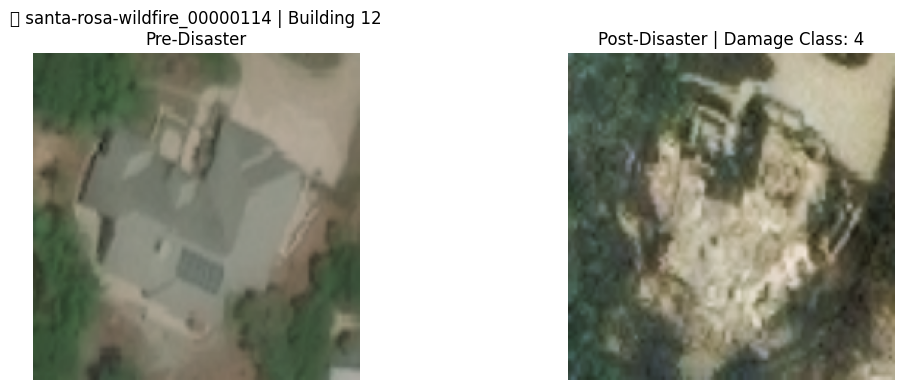

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random

def plot_pre_post_samples(paths_dict, n_samples=3):
    """
    Randomly plots a few pre/post image pairs with their damage labels
    from the cropped dataset.
    """
    # Collect all (img_id, building_id, data) tuples
    all_buildings = [
        (img_id, b_id, data)
        for img_id, buildings in paths_dict.items()
        for b_id, data in buildings.items()
    ]

    # Shuffle for randomness
    random.shuffle(all_buildings)

    # Pick N samples
    samples = all_buildings[:n_samples]

    # Plot
    plt.figure(figsize=(12, n_samples * 4))

    for idx, (img_id, b_id, data) in enumerate(samples, 1):
        pre_path = data['pre_path']
        post_path = data['post_path']
        label = data['label']

        pre_img = Image.open(pre_path)
        post_img = Image.open(post_path)

        # Pre
        plt.subplot(n_samples, 2, (idx - 1) * 2 + 1)
        plt.imshow(pre_img)
        plt.axis("off")
        plt.title(f"🧱 {img_id} | Building {b_id}\nPre-Disaster")

        # Post
        plt.subplot(n_samples, 2, (idx - 1) * 2 + 2)
        plt.imshow(post_img)
        plt.axis("off")
        plt.title(f"Post-Disaster | Damage Class: {label}")

    plt.tight_layout()
    plt.show()
plot_pre_post_samples(data_paths, n_samples=1)

In [ ]:
import pandas as pd

def data_paths_to_df(data_paths):
    records = []

    for image_id, buildings in data_paths.items():
        for b_id, info in buildings.items():
            records.append({
                'image_id': image_id,
                'building_id': b_id,
                'label': info.get('label'),
                'pre_path': info.get('pre_path'),
                'post_path': info.get('post_path')
            })

    df = pd.DataFrame(records)
    return df

# Example usage
df = data_paths_to_df(data_paths)



In [ ]:
df['label'].value_counts()

label
1    569
4    129
3     98
2     66
Name: count, dtype: int64